## Feature Engineering and Preprocessing


**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
  - [Importing Libraries](#toc1_1_)    
- [Loading dataset](#toc2_)    
- [Time based Feature Engineering](#toc3_)    
  - [Weekend Feature](#toc3_1_)    
- [Autocorrelation Analysis](#toc4_)    
  - [Statistical Stationarity](#toc4_1_)    
  - [ACF and PACF plots](#toc4_2_)    
  - [Rolling Statistics](#toc4_3_)    
- [Conclusion](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=3
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_'></a>[Introduction](#toc0_)

In this notebook, we perform comprehensive feature engineering and preprocessing on the power consumption dataset to prepare it for time series modeling and forecasting. 

The workflow includes importing the clean data, creating time-based and cyclical features, analyzing autocorrelation and stationarity, and generating rolling statistics and lagged variables. These steps are designed to capture both short-term and long-term temporal patterns, as well as the effects of exogenous variables, enabling robust modeling of power consumption across different zones

#### <a id='toc1_1_'></a>[Importing Libraries](#toc0_)

Importing necessary libraries for data pre-processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical libraries
from scipy import stats
from statsmodels.api import tsa
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Ignore all warnings to avoid cluttering the output
import warnings
warnings.filterwarnings("ignore")

# set matplotlib global settings eg. figsize
plt.rcParams['figure.figsize'] = (8.0, 6.0) 

sns.set_style("darkgrid")  #Setting grid style in seaborn


### <a id='toc2_'></a>[Loading dataset](#toc0_)

Overview: Contains dataset after prelimnary analysis.

Step: Importing cleaned data post EDA into a dataframe power_df.

In [2]:
power_df = pd.read_pickle('../data/power_df_clean.pkl')

power_df.head()

,Temperature,Humidity,Wind_Speed,General_Diffuse_Flows,Diffuse_Flows,Zone1_Power_Consumption,Zone2_Power_Consumption,Zone3_Power_Consumption,Hour,DayOfWeek,Month,General_Diffuse_Flows_Log,Diffuse_Flows_Log
DateTime,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,6,1,-2.975930,-2.128632
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,1,-2.659260,-2.465104
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,1,-2.780621,-2.302585
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,1,-2.396896,-2.343407
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,1,-3.036554,-2.465104


### <a id='toc3_'></a>[Time based Feature Engineering](#toc0_)

We have already created key time-based features such as **Hour**, **DayOfWeek**, and **Month** during the exploratory data analysis (EDA). 

Now, we will create a **Weekend** feature. This binary indicator will help us explicitly distinguish between weekdays and weekends, allowing us to analyze and model differences in power usage patterns that are often driven by work schedules, social activities, and operational changes in different zones.

#### <a id='toc3_1_'></a>[Weekend Feature](#toc0_)

In [3]:
power_df['is_weekend'] = np.where(power_df['DayOfWeek']>=5,1,0)
power_df['DayOfWeek'].unique()

array([6, 0, 1, 2, 3, 4, 5], dtype=int32)

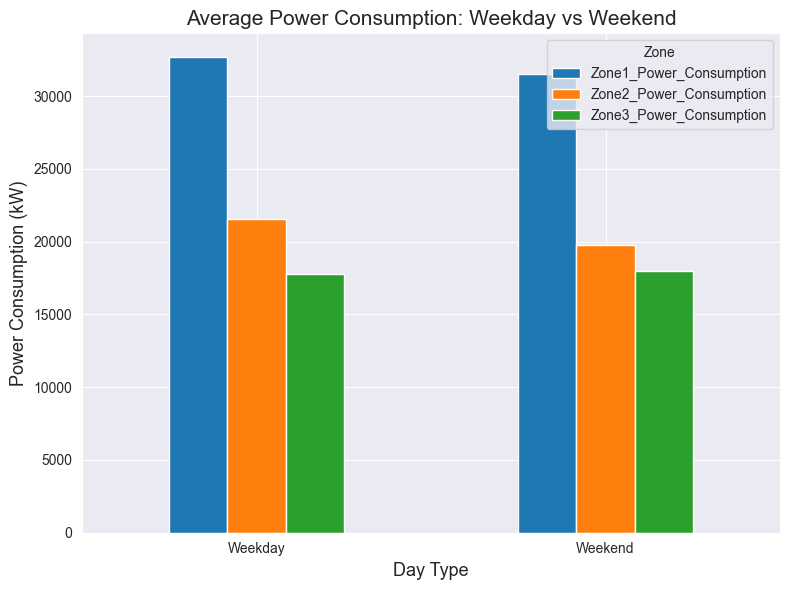

In [4]:
# Visualize average power consumption for weekends vs weekdays in all zones
zones = ['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']
weekend_avg = power_df.groupby('is_weekend')[zones].mean()
weekend_avg.index = ['Weekday', 'Weekend']

weekend_avg.plot(kind='bar')
plt.title('Average Power Consumption: Weekday vs Weekend',fontsize=15)
plt.xlabel('Day Type',fontsize=13)
plt.ylabel('Power Consumption (kW)',fontsize=13)
plt.legend(title='Zone')
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()

Key Insights:

- Typically, power consumption is higher on weekdays compared to weekends, reflecting changes in activity and operational schedules.
- The magnitude of the difference varies by zone, indicating that each zone may have distinct usage behaviors or functions.
- These insights highlight the importance of including the `is_weekend` feature for modeling, as it captures meaningful variation in power demand across different days of the week.

### <a id='toc4_'></a>[Autocorrelation Analysis](#toc0_)

In this section, we use autocorrelation (ACF) and partial autocorrelation (PACF) plots to identify the most relevant lag features for modeling power consumption. These plots help us understand how strongly current values are related to their past values at different time lags.

- **ACF (Autocorrelation Function):** Shows the correlation between a time series and its own previous values over various lags. High autocorrelation at a specific lag suggests that including that lag as a feature may improve forecasting.
- **PACF (Partial Autocorrelation Function):** Measures the correlation between a time series and its lagged values, after removing the influence of shorter lags. This helps pinpoint which lags provide unique information for prediction.

By analyzing ACF and PACF plots for each zone, we can select the most informative lag features to capture temporal dependencies in the dataset.

#### <a id='toc4_1_'></a>[Statistical Stationarity](#toc0_)

Before calculating autocorrelation plots, it is important to check for stationarity in the data. Stationarity ensures that the statistical properties of the time series do not change over time, which is a key assumption for autocorrelation analysis. We use statistical tests to assess stationarity and apply differencing if needed to make the series stationary.

In [5]:
# Statistical stationarity tests: ADF and KPSS

for zone in zones:
    print(f"\nChecking stationarity for {zone}:")
    adf_result = adfuller(power_df[zone].dropna())
    kpss_result = kpss(power_df[zone].dropna(), nlags="auto")
    print(f"ADF Statistic: {adf_result[0]:.2f}, p-value: {adf_result[1]:.4f}")
    print(f"KPSS Statistic: {kpss_result[0]:.2f}, p-value: {kpss_result[1]:.4f}")

    if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
        print("Both tests suggest STATIONARY")
    elif adf_result[1] > 0.05 and kpss_result[1] < 0.05:
        print("Both tests suggest NON-STATIONARY")
    elif adf_result[1] < 0.05 and kpss_result[1] < 0.05:
        print("CONFLICTING RESULTS - ADF indicated STATIONARY while KPSS indicates NON-STATIONARY")
    elif adf_result[1] > 0.05 and kpss_result[1] > 0.05:
        print("CONFLICTING RESULTS - KPSS indicated STATIONARY while ADF indicates NON-STATIONARY")


Checking stationarity for Zone1_Power_Consumption:
ADF Statistic: -32.12, p-value: 0.0000
KPSS Statistic: 6.02, p-value: 0.0100
CONFLICTING RESULTS - ADF indicated STATIONARY while KPSS indicates NON-STATIONARY

Checking stationarity for Zone2_Power_Consumption:
ADF Statistic: -25.22, p-value: 0.0000
KPSS Statistic: 16.86, p-value: 0.0100
CONFLICTING RESULTS - ADF indicated STATIONARY while KPSS indicates NON-STATIONARY

Checking stationarity for Zone3_Power_Consumption:
ADF Statistic: -16.37, p-value: 0.0000
KPSS Statistic: 8.93, p-value: 0.0100
CONFLICTING RESULTS - ADF indicated STATIONARY while KPSS indicates NON-STATIONARY


In [6]:
# KPSS stationarity test after differencing

for zone in zones:
    print(f"\n Checking stationarity for {zone} after first-order differencing using KPSS:")
    kpss_diff_result = kpss(power_df[zone].diff().dropna(), nlags="auto")
    print(f"KPSS Statistic: {kpss_result[0]:.2f}, p-value: {kpss_result[1]:.4f}")
    if kpss_diff_result[1] > 0.05:
        print("Differenced series is stationary.")
    else:
        print("Differenced series is still non-stationary. Consider further differencing or transformation.")


 Checking stationarity for Zone1_Power_Consumption after first-order differencing using KPSS:
KPSS Statistic: 8.93, p-value: 0.0100
Differenced series is stationary.

 Checking stationarity for Zone2_Power_Consumption after first-order differencing using KPSS:
KPSS Statistic: 8.93, p-value: 0.0100
Differenced series is stationary.

 Checking stationarity for Zone3_Power_Consumption after first-order differencing using KPSS:
KPSS Statistic: 8.93, p-value: 0.0100
Differenced series is stationary.


Since the data indicated clear non-stationarity seasonal patterns during EDA, we evaluated stationarity using both the KPSS and ADF tests.
- The KPSS test indicated that the original series was non-stationary. After applying first-order differencing, the KPSS test results suggested that the series became stationary.
- The ADF test, however, reported the original series as stationary. This apparent contradiction may stem from the high-frequency (10-minute interval) nature of the data and the presence of strong seasonality. Such patterns can confuse the ADF test and mask underlying non-stationarity.

- In such cases, KPSS is more reliable for detecting stationarity, especially when seasonality is present.

#### <a id='toc4_2_'></a>[ACF and PACF plots](#toc0_)

Now we will plot the ACF and PACF for each zone. This helps us visualize the autocorrelation and partial autocorrelation structure of the power consumption time series, making it easier to identify the most relevant lag features and determine appropriate model orders for time series forecasting.

We will generate these plots for both the original 10-minute data and the resampled hourly data to better understand temporal dependencies and seasonal patterns at different time scales.

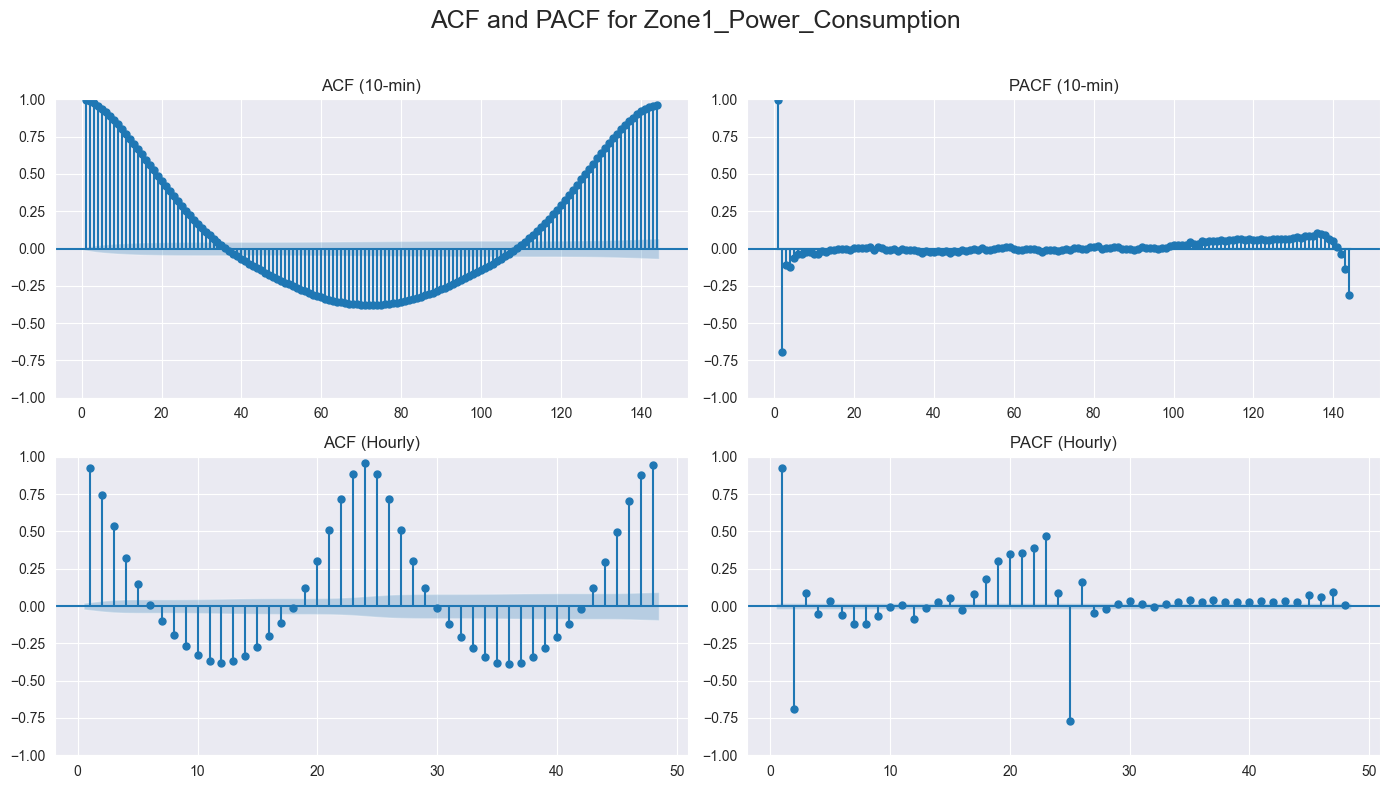

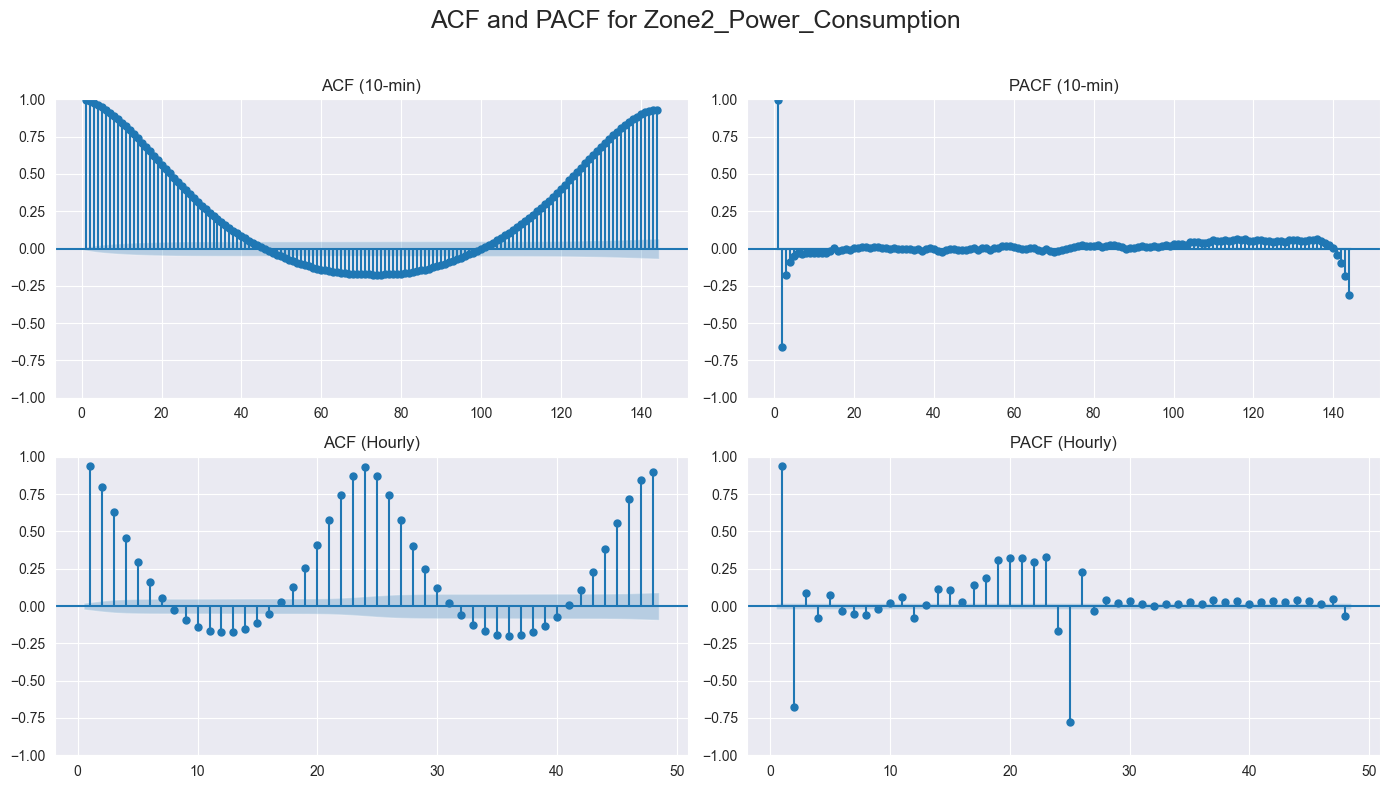

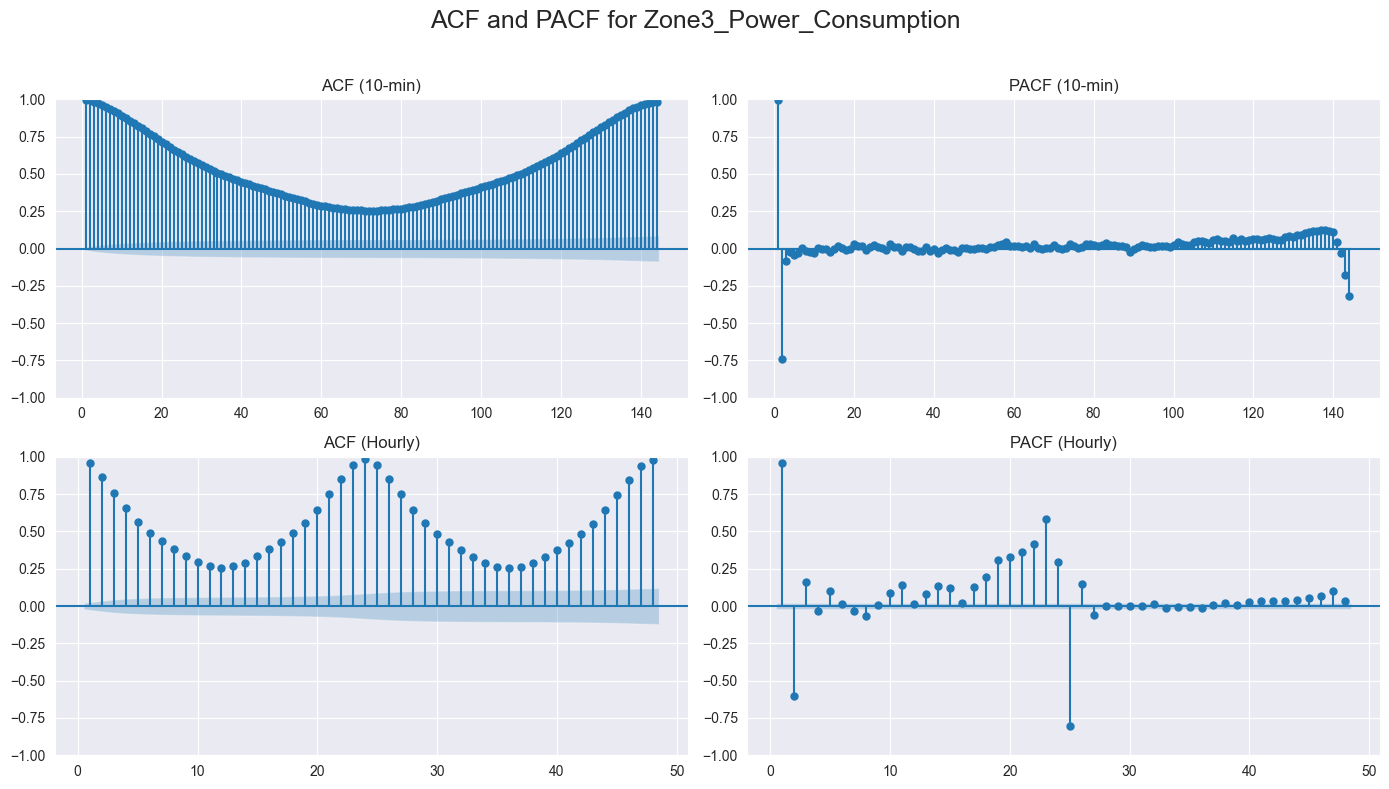

In [7]:
zones = ['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']

# List of exogenous features (excluding zones)
exog_features = ['Temperature', 'Humidity', 'General_Diffuse_Flows']

# Resample zones and exogenous features to hourly frequency
power_hourly = power_df[zones + exog_features].resample('1H').mean()

# For binary/categorical features like 'is_weekend', use .max() instead of .mean()
power_hourly['is_weekend'] = power_df['is_weekend'].resample('1H').max()

for zone in zones:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle(f'ACF and PACF for {zone}', fontsize=18)
    
    # Original (10-min) data
    plot_acf(power_df[zone], lags=144, zero=False, ax=axes[0, 0])
    axes[0, 0].set_title('ACF (10-min)')
    plot_pacf(power_df[zone], lags=144, zero=False, ax=axes[0, 1])
    axes[0, 1].set_title('PACF (10-min)')
    
    # Hourly resampled data
    plot_acf(power_hourly[zone], lags=48, zero=False, ax=axes[1, 0])
    axes[1, 0].set_title('ACF (Hourly)')
    plot_pacf(power_hourly[zone], lags=48, zero=False, ax=axes[1, 1])
    axes[1, 1].set_title('PACF (Hourly)')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Key Findings from *10 min data*

- **ACF Pattern**: Gradual oscillating decay, indicating AR components are needed
- **PACF Pattern**: Sharp cutoff after lag 1-2, suggesting AR(1) or AR(2) structure
- **Seasonality**: Pronounced daily cycles visible at 144-lag intervals, showing seasonality is present and not yet removed.
- All three zones show similar patterns, suggesting consistent modeling approach

Key Insights from resampled *hourly* data:

- Hourly data preserves the strong daily pattern seen in 10-minute data but offers cleaner, less complex autocorrelation and seasonality structures—making SARIMA modeling simpler and more robust. Therefore, we use SARIMA modeling on hourly data in the next section, also keeping the computational constraints in mind. 

- **SARIMA Model Orders**: Based on ACF/PACF analysis, we will be fitting SARIMAX with seasonal orders (P=0-1, D=0-1, Q=0-1, m=24) and non-seasonal orders (p=1-2, d=01, q=0-1) for all zones, and selecting best model based on evaluation metrics.


#### <a id='toc4_3_'></a>[Rolling Statistics](#toc0_)

In this section, we analyze the rolling statistics of power consumption for each zone to better understand short-term and long-term trends and variability in the data. 

By calculating rolling means, standard deviations, and medians over different window sizes, we can visualize how consumption patterns and volatility change throughout the day and across seasons. 

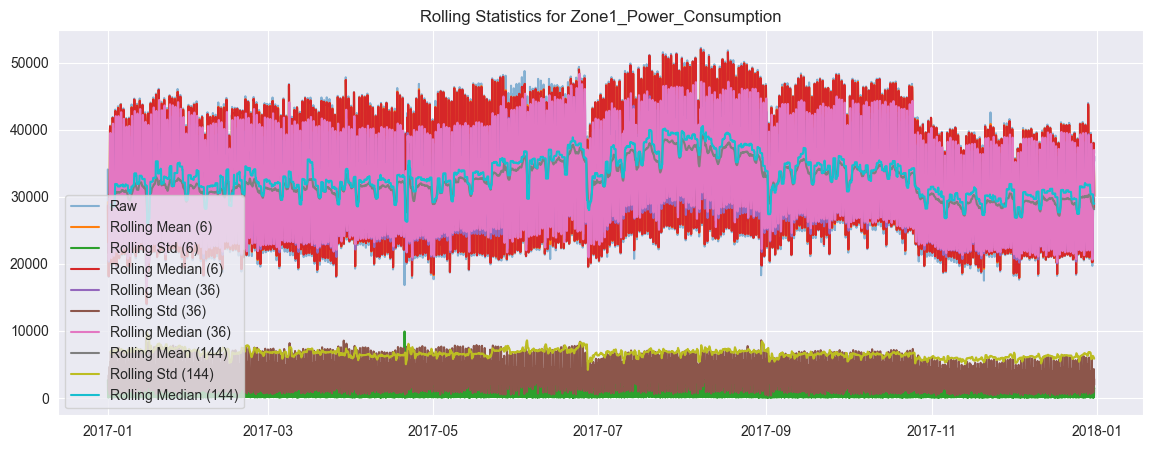

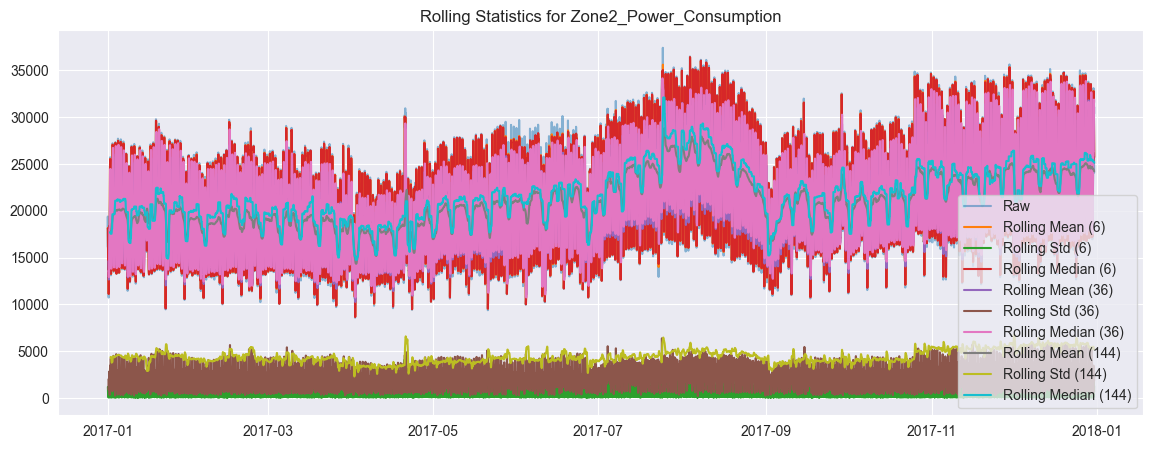

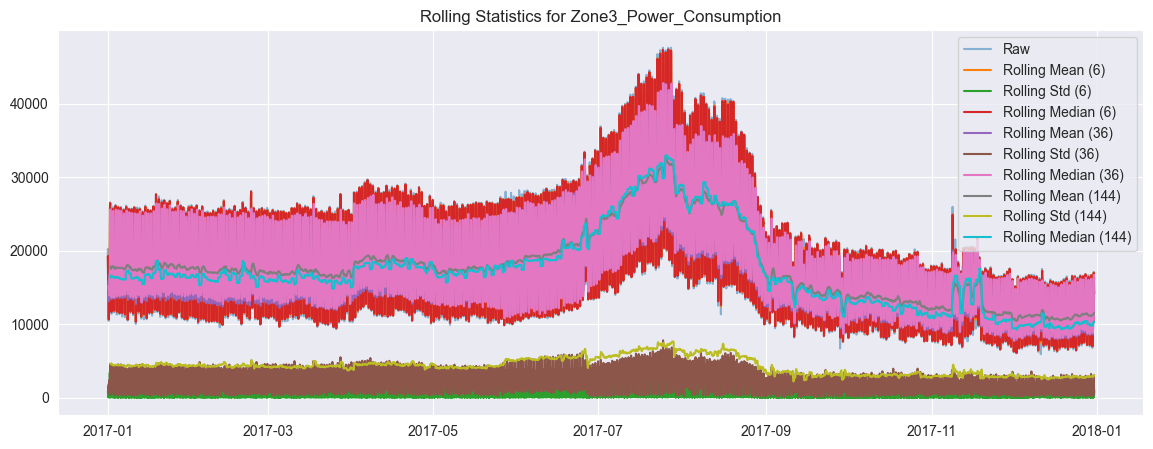

In [8]:
window_sizes = [6, 36, 144]  # 1 hour, 4 hours, 1 day (for 10-min data)
for zone in zones:
    plt.figure(figsize=(14, 5))
    plt.plot(power_df[zone], label='Raw',alpha=0.5)
    for w in window_sizes:
        plt.plot(power_df[zone].rolling(window=w).mean(), label=f'Rolling Mean ({w})')
        plt.plot(power_df[zone].rolling(window=w).std(), label=f'Rolling Std ({w})')
        plt.plot(power_df[zone].rolling(window=w).median(), label=f'Rolling Median ({w})')
    plt.title(f'Rolling Statistics for {zone}')
    plt.legend()
    plt.show()

Key Insights:

All zones show clear daily cycles in rolling statistics, consistent with our prelimnary analysis 

- **Zone 1:**  
  - Shows the most stable rolling mean and lowest rolling standard deviation, indicating consistent consumption patterns.

- **Zone 2:**  
  - Displays moderate variability in rolling mean and standard deviation.

- **Zone 3:**  
  - Exhibits the highest rolling standard deviation and the most pronounced peaks in rolling mean, especially during summer.

We will now engineer rolling statistics and lagged features for all power consumption zones. Additionally, we will transform discrete time features such as `Hour` and `DayOfWeek` into continuous cyclical features using sine and cosine transformations, enabling models to better capture periodic behaviors.

In [9]:
# Cyclical time features for Hour and DayOfWeek
power_df['Hour_sin'] = np.sin(2 * np.pi * power_df['Hour'] / 24)
power_df['Hour_cos'] = np.cos(2 * np.pi * power_df['Hour'] / 24)
power_df['DayOfWeek_sin'] = np.sin(2 * np.pi * power_df['DayOfWeek'] / 7)
power_df['DayOfWeek_cos'] = np.cos(2 * np.pi * power_df['DayOfWeek'] / 7)

zones = ['Zone1_Power_Consumption', 'Zone2_Power_Consumption', 'Zone3_Power_Consumption']

# Rolling windows sizes in periods (10 min frequency)
roll_windows = {'1h': 6, '6h': 36, '1d': 144}

# Create rolling and lagged features for all zones
for zone in zones:
    # Immediate Lag feature 
    power_df[f'{zone}_lag_1'] = power_df[zone].shift(1) 
    # Seasonal lag features (lags at 1 day)
    power_df[f'{zone}_lag_1d'] = power_df[zone].shift(144)
    for name, window in roll_windows.items():
        power_df[f'{zone}_rolling_mean_{name}'] = power_df[zone].shift(1).rolling(window=window).mean()
        power_df[f'{zone}_rolling_std_{name}'] = power_df[zone].shift(1).rolling(window=window).std()
        power_df[f'{zone}_rolling_min_{name}'] = power_df[zone].shift(1).rolling(window=window).min()
        power_df[f'{zone}_rolling_max_{name}'] = power_df[zone].shift(1).rolling(window=window).max()
        power_df[f'{zone}_rolling_median_{name}'] = power_df[zone].shift(1).rolling(window=window).median()

power_df.dropna(inplace=True)  # drop NaNs after shifts and rolling

### Saving final dataset

In [12]:
# Pickle the Final DataFrame
power_df.to_pickle('../data/power_df_preprocessed.pkl')
power_hourly.to_pickle('../data/power_hourly_preprocessed.pkl')

### <a id='toc5_'></a>[Conclusion](#toc0_)

In this notebook, we performed systematic feature engineering and preprocessing on the power consumption dataset to prepare it for time series modeling. We created time-based and cyclical features, engineered lagged variables and rolling statistics for each zone, and analyzed autocorrelation and stationarity to guide our feature choices. 

The resulting dataset is well-suited for robust forecasting and further modeling, providing a strong foundation for subsequent analysis and model development.